# PPO Training for Stock Trading

This notebook implements Proximal Policy Optimization (PPO) for training a reinforcement learning agent to trade stocks.

## Overview
- **Environment**: Stock trading environment using historical price data
- **Algorithm**: PPO (Proximal Policy Optimization)
- **Model**: Actor-Critic network (MLP or CNN)
- **Features**: Volume, extra features (volatility, ATR-like), chronological train/val split


## 1. Imports and Setup


In [1]:
import os
import time
import random

import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from tensorboardX import SummaryWriter

# Import our stock trading environment package
from stock_trading_env import (
    StocksEnv,
    load_many_from_dir,
    split_many_by_ratio,
    Actions,
)

# ---------- Reproducibility ----------
def set_seed(seed: int, deterministic: bool = True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Pick a default seed (match your CLI default if you had one)
SEED = 0
set_seed(SEED, deterministic=True)

# ---------- Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Output directories ----------
os.makedirs("runs", exist_ok=True)
os.makedirs("saves", exist_ok=True)
os.makedirs("logs", exist_ok=True)

print("✓ Imports successful")
print(f"Seed: {SEED} (deterministic=True)")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✓ Imports successful
Seed: 0 (deterministic=True)
PyTorch version: 2.9.0+cpu
CUDA available: False
Device: cpu


## 2. PPO Model Definitions

Define the Actor-Critic networks for PPO.


In [2]:
# Cell 2: PPO Actor-Critic models (DISCRETE actions) — matches earlier repo logic

import torch
import torch.nn as nn


class ActorCriticMLP(nn.Module):
    """
    PPO Actor-Critic for DISCRETE actions (vector observation).

    Input:  x (B, obs_dim)
    Output: logits (B, n_actions), value (B,)
      - logits are unnormalized scores for torch.distributions.Categorical(logits=logits)
      - value is V(s) for GAE/advantage estimation
    """

    def __init__(self, obs_dim: int, n_actions: int, hidden: int = 256):
        super().__init__()

        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        self.policy_head = nn.Linear(hidden, n_actions)
        self.value_head = nn.Linear(hidden, 1)

        self._init_weights()

    def _init_weights(self):
        # Orthogonal init is common for PPO
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=1.0)
                nn.init.constant_(m.bias, 0.0)

        # Smaller gain for the final policy head helps early training stability
        nn.init.orthogonal_(self.policy_head.weight, gain=0.01)
        nn.init.constant_(self.policy_head.bias, 0.0)

    def forward(self, x: torch.Tensor):
        z = self.shared(x)
        logits = self.policy_head(z)
        value = self.value_head(z).squeeze(-1)
        return logits, value


class ActorCriticConv1D(nn.Module):
    """
    PPO Actor-Critic for State1D observations (CNN over time bars).

    Expected env State1D shape (C, T) where:
      - C = (3 + (1 if volumes else 0)) + 2  -> typically 6 if volumes=True
      - T = bars_count (e.g., 10)

    Input:  x (B, C, T)
    Output: logits (B, n_actions), value (B,)
    """

    def __init__(self, n_actions: int, bars_count: int, volumes: bool = True, hidden: int = 256):
        super().__init__()

        # Match env.State1D channel logic:
        # base channels: 3 + (1 if volumes else 0)
        # +2 for (have_position, unrealized_return)
        in_channels = (3 + (1 if volumes else 0)) + 2

        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten(),  # -> (B, 64 * bars_count)
        )

        conv_out = 64 * bars_count

        self.shared = nn.Sequential(
            nn.Linear(conv_out, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
        )

        self.policy_head = nn.Linear(hidden, n_actions)
        self.value_head = nn.Linear(hidden, 1)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.orthogonal_(m.weight, gain=1.0)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.0)

        nn.init.orthogonal_(self.policy_head.weight, gain=0.01)
        nn.init.constant_(self.policy_head.bias, 0.0)

    def forward(self, x: torch.Tensor):
        feat = self.conv(x)
        z = self.shared(feat)
        logits = self.policy_head(z)
        value = self.value_head(z).squeeze(-1)
        return logits, value


print("✓ PPO models defined (MLP + Conv1D)")
print("  - Use ActorCriticMLP for vector obs")
print("  - Use ActorCriticConv1D only if env returns State1D (C,T), e.g. (6, bars)")

✓ PPO models defined (MLP + Conv1D)
  - Use ActorCriticMLP for vector obs
  - Use ActorCriticConv1D only if env returns State1D (C,T), e.g. (6, bars)


## 3. PPO Buffer and Utilities

Define the rollout buffer for collecting experience and computing GAE advantages.


In [3]:
# Cell 3 (updated): RolloutBuffer + PPOBatch
# Fixes/robustness:
# - Safer dtype/device handling
# - Enforces add() obs shape
# - Handles truncated/terminated properly via done float
# - Supports 1D (vector) and 2D (C,T) observations cleanly
# - Compute GAE in float32, normalize advantages safely
# - Optional pin_memory for faster CPU->GPU transfer

from dataclasses import dataclass
from typing import Iterator, Optional, Tuple, Union

import numpy as np
import torch


@dataclass
class PPOBatch:
    """One minibatch used during PPO updates."""
    obs: torch.Tensor
    actions: torch.Tensor
    old_logprobs: torch.Tensor
    advantages: torch.Tensor
    returns: torch.Tensor
    old_values: torch.Tensor


class RolloutBuffer:
    """
    Fixed-length rollout buffer for PPO.

    Stores:
      obs[t], action[t], reward[t], done[t], value[t], logprob[t]

    After calling compute_gae():
      advantages[t], returns[t] are filled.

    Notes:
      - done should be True when episode ended for ANY reason:
        done = terminated OR truncated (Gymnasium).
      - obs can be vector (obs_dim,) or State1D (C,T).
    """

    def __init__(
        self,
        obs_shape: Union[int, Tuple[int, ...]],
        size: int,
        device: Union[str, torch.device] = "cpu",
        obs_dtype: np.dtype = np.float32,
        pin_memory: bool = False,
    ):
        if isinstance(obs_shape, int):
            obs_shape = (obs_shape,)
        self.obs_shape = tuple(obs_shape)
        self.size = int(size)
        self.device = torch.device(device) if not isinstance(device, torch.device) else device
        self.pin_memory = bool(pin_memory) and (self.device.type == "cuda")

        # Storage (numpy)
        self.obs = np.zeros((self.size, *self.obs_shape), dtype=obs_dtype)
        self.actions = np.zeros((self.size,), dtype=np.int64)
        self.rewards = np.zeros((self.size,), dtype=np.float32)
        self.dones = np.zeros((self.size,), dtype=np.float32)   # 1.0 if done else 0.0
        self.values = np.zeros((self.size,), dtype=np.float32)
        self.logprobs = np.zeros((self.size,), dtype=np.float32)

        # Computed after rollout
        self.advantages = np.zeros((self.size,), dtype=np.float32)
        self.returns = np.zeros((self.size,), dtype=np.float32)

        self.ptr = 0
        self.full = False

    def reset(self):
        self.ptr = 0
        self.full = False

    def add(
        self,
        obs: np.ndarray,
        action: int,
        reward: float,
        done: bool,
        value: float,
        logprob: float,
    ):
        """Add one transition."""
        if self.ptr >= self.size:
            raise RuntimeError("RolloutBuffer is full. Call reset() before adding more.")

        obs_arr = np.asarray(obs, dtype=self.obs.dtype)

        # Enforce shape to catch silent bugs early (common in notebooks)
        if obs_arr.shape != self.obs_shape:
            raise ValueError(
                f"Obs shape mismatch: got {obs_arr.shape}, expected {self.obs_shape}. "
                "Check env output (vector vs State1D) and model input."
            )

        self.obs[self.ptr] = obs_arr
        self.actions[self.ptr] = int(action)
        self.rewards[self.ptr] = float(reward)
        self.dones[self.ptr] = 1.0 if bool(done) else 0.0
        self.values[self.ptr] = float(value)
        self.logprobs[self.ptr] = float(logprob)

        self.ptr += 1
        self.full = (self.ptr == self.size)

    @torch.no_grad()
    def compute_gae(
        self,
        last_value: float,
        gamma: float = 0.99,
        lam: float = 0.95,
        normalize_adv: bool = True,
        eps: float = 1e-8,
    ):
        """
        Compute GAE(lambda) advantages and returns.

        last_value should be V(s_T) for the *last obs after the rollout*,
        used to bootstrap if the last transition was not terminal.
        """
        if not self.full:
            raise RuntimeError("RolloutBuffer not full. Collect 'size' steps before compute_gae().")

        last_value = float(last_value)

        adv = 0.0
        for t in reversed(range(self.size)):
            done = self.dones[t]
            mask = 1.0 - done  # 0 if terminal else 1

            next_value = last_value if (t == self.size - 1) else float(self.values[t + 1])
            delta = float(self.rewards[t]) + gamma * next_value * mask - float(self.values[t])

            adv = delta + gamma * lam * mask * adv
            self.advantages[t] = adv

        # returns target for critic
        self.returns = self.advantages + self.values

        if normalize_adv:
            m = float(self.advantages.mean())
            s = float(self.advantages.std())
            self.advantages = (self.advantages - m) / (s + eps)

    def get_batches(self, batch_size: int, shuffle: bool = True) -> Iterator[PPOBatch]:
        """Yield mini-batches as torch tensors."""
        if not self.full:
            raise RuntimeError("RolloutBuffer not full. Collect rollout before batching.")

        if batch_size <= 0:
            raise ValueError("batch_size must be > 0")

        idxs = np.arange(self.size)
        if shuffle:
            np.random.shuffle(idxs)

        for start in range(0, self.size, batch_size):
            b_idx = idxs[start : start + batch_size]

            # CPU tensors first (optionally pinned), then move to device
            obs_cpu = torch.from_numpy(self.obs[b_idx]).float()
            if self.pin_memory:
                obs_cpu = obs_cpu.pin_memory()
            obs_t = obs_cpu.to(self.device, non_blocking=self.pin_memory)

            actions_t = torch.from_numpy(self.actions[b_idx]).long().to(self.device)
            old_logp_t = torch.from_numpy(self.logprobs[b_idx]).float().to(self.device)
            adv_t = torch.from_numpy(self.advantages[b_idx]).float().to(self.device)
            ret_t = torch.from_numpy(self.returns[b_idx]).float().to(self.device)
            old_v_t = torch.from_numpy(self.values[b_idx]).float().to(self.device)

            yield PPOBatch(
                obs=obs_t,
                actions=actions_t,
                old_logprobs=old_logp_t,
                advantages=adv_t,
                returns=ret_t,
                old_values=old_v_t,
            )


print("✓ PPO buffer defined (updated/robust)")

✓ PPO buffer defined (updated/robust)


# Cell 4

In [4]:
from typing import Dict, Any
import numpy as np
import torch
from torch.distributions import Categorical

@torch.no_grad()
def policy_act(model, obs, device: torch.device, greedy: bool = False):
    """
    Sample (or greedy-select) action from current policy.
    Returns: action(int), logprob(float), value(float)
    Works for both:
      - vector obs: (obs_dim,)
      - State1D obs: (C, T)
    """
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    logits, value = model(obs_t)
    dist = Categorical(logits=logits)

    if greedy:
        action_t = torch.argmax(logits, dim=1)
    else:
        action_t = dist.sample()

    logprob_t = dist.log_prob(action_t)
    return int(action_t.item()), float(logprob_t.item()), float(value.item())


def explained_variance(y_pred: np.ndarray, y_true: np.ndarray) -> float:
    """1 - Var[y_true - y_pred] / Var[y_true]. Diagnostic for critic fit."""
    var_y = float(np.var(y_true))
    if var_y < 1e-12:
        return 0.0
    return float(1.0 - np.var(y_true - y_pred) / (var_y + 1e-12))


@torch.no_grad()
def validation_run_ppo(env, model, episodes: int = 50, device="cpu", greedy: bool = True) -> Dict[str, float]:
    """
    Evaluate a PPO policy on the given environment.
    Returns mean metrics across episodes.

    IMPORTANT: This assumes the env executes actions at OPEN(t+1), consistent with your repo env.
    """
    device = torch.device(device) if not isinstance(device, torch.device) else device

    # Ensure deterministic eval behavior (dropout/bn etc.)
    was_training = model.training
    model.eval()

    base_env = env.unwrapped if hasattr(env, "unwrapped") else env
    st = getattr(base_env, "_state", None)
    if st is None:
        # restore mode before raising
        if was_training:
            model.train()
        raise AttributeError("validation_run_ppo expected env.unwrapped to have attribute '_state'.")

    stats = {
        "episode_reward": [],
        "episode_steps": [],
        "num_trades": [],
        "win_rate": [],
        "avg_trade_return": [],
        "avg_hold_steps": [],
        "sum_trade_return": [],
    }

    for _ in range(episodes):
        obs, info = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        # Manual trade tracking (OPEN(t+1) execution)
        in_pos = False
        entry_price = None
        hold_steps = 0
        trade_returns = []
        trade_hold_steps = []

        while not done:
            action, _lp, _v = policy_act(model, obs, device=device, greedy=greedy)

            # Safer enum conversion
            try:
                act_enum = Actions(action)
            except Exception:
                # If action is invalid, treat as "Skip" (safe fallback)
                act_enum = Actions.Skip

            # Access state after reset/step (base_env._state can change reference)
            st = base_env._state
            next_idx = st._offset + 1

            exec_open = None
            if 0 <= next_idx < st._prices.open.shape[0]:
                exec_open = float(st._prices.open[next_idx])

            prev_have_pos_env = bool(st.have_position)

            # Bookkeeping BEFORE env.step(), using OPEN(t+1)
            if exec_open is not None:
                if act_enum == Actions.Buy and not in_pos:
                    in_pos = True
                    entry_price = exec_open
                    hold_steps = 0
                elif act_enum == Actions.Close and in_pos:
                    if entry_price is not None and entry_price > 0:
                        tr = 100.0 * (exec_open - entry_price) / entry_price
                    else:
                        tr = 0.0
                    trade_returns.append(tr)
                    trade_hold_steps.append(hold_steps)
                    in_pos = False
                    entry_price = None
                    hold_steps = 0

            # Step environment
            obs, reward, terminated, truncated, info = env.step(action)
            done = bool(terminated or truncated)
            total_reward += float(reward)
            steps += 1

            # Detect forced close by env (stop-loss / done close, etc.)
            now_have_pos_env = bool(base_env._state.have_position)
            if in_pos and prev_have_pos_env and (not now_have_pos_env) and act_enum != Actions.Close:
                # Use exec_open if available (OPEN(t+1)), else fallback to current close
                exit_price = exec_open if exec_open is not None else float(base_env._state._cur_close())
                if entry_price is not None and entry_price > 0:
                    tr = 100.0 * (exit_price - entry_price) / entry_price
                else:
                    tr = 0.0
                trade_returns.append(tr)
                trade_hold_steps.append(hold_steps)
                in_pos = False
                entry_price = None
                hold_steps = 0

            if in_pos:
                hold_steps += 1

        # If episode ends while holding, close at last close for reporting
        if in_pos and entry_price is not None and entry_price > 0:
            last_close = float(base_env._state._cur_close())
            tr = 100.0 * (last_close - entry_price) / entry_price
            trade_returns.append(tr)
            trade_hold_steps.append(hold_steps)

        # Episode metrics
        stats["episode_reward"].append(total_reward)
        stats["episode_steps"].append(steps)

        n_trades = len(trade_returns)
        stats["num_trades"].append(float(n_trades))

        if n_trades > 0:
            wins = sum(1 for x in trade_returns if x > 0.0)
            stats["win_rate"].append(float(wins / n_trades))
            stats["avg_trade_return"].append(float(np.mean(trade_returns)))
            stats["avg_hold_steps"].append(float(np.mean(trade_hold_steps)))
            stats["sum_trade_return"].append(float(np.sum(trade_returns)))
        else:
            stats["win_rate"].append(0.0)
            stats["avg_trade_return"].append(0.0)
            stats["avg_hold_steps"].append(0.0)
            stats["sum_trade_return"].append(0.0)

    # Restore model mode
    if was_training:
        model.train()

    return {k: float(np.mean(v)) for k, v in stats.items()}


print("✓ Helper functions defined (updated/robust)")

✓ Helper functions defined (updated/robust)


# Cell 5

In [5]:
# ===== Training Configuration (CLI-aligned + holding cost + reason-to-close shaping) =====
config = {
    # Data
    "data_dir": "yf_data",
    "run_name": "ppo_aapl_final_holdpen_2e-4_closebonus_0p15_uloss_0p10_uvol_0p00",
    "seed": 0,

    # Device
    "use_cuda": True,

    # PPO Hyperparameters (UNCHANGED)
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "clip_eps": 0.2,
    "lr": 3e-4,
    "rollout_steps": 1024,
    "minibatch": 256,
    "epochs": 5,
    "value_coef": 0.5,
    "entropy_coef": 0.025,
    "max_grad_norm": 0.5,
    "target_kl": 0.03,

    # Environment
    "bars": 10,
    "volumes": True,
    "extra_features": True,
    "reward_mode": "close_pnl",
    "state_1d": False,
    "time_limit": 1000,

    # Holding-cost controls
    "hold_penalty_per_step": 2e-4,
    "max_hold_steps": None,

    # >>> NEW: Reason-to-close shaping (START CONSERVATIVE) <<<
    # Penalize holding unrealized losses (scaled by magnitude of negative unrealized return)
    "unrealized_loss_penalty_per_step": 0.10,   # try 0.05–0.20
    # Bonus when closing profitable trades (scaled by realized return)
    "close_profit_bonus": 0.20,                 # try 0.05–0.30
    # Penalize volatility while holding (start at 0.0; add later if needed)
    "unrealized_vol_penalty_per_step": 0.00,    # keep 0.0 initially
    "vol_lookback": 20,

    # Data Split
    "split": True,
    "train_ratio": 0.8,
    "min_train": 300,
    "min_val": 300,

    # Training Control
    "max_rollouts": 500,
    "total_steps": 10_000_000,

    # Validation & Checkpointing
    "val_every_rollouts": 10,
    "save_every_rollouts": 5,
    "early_stop": True,
    "patience": 20,
    "min_rollouts": 50,
    "min_delta": 0.01,
}

# Set device (matches --cuda behavior)
device = torch.device("cuda" if (config["use_cuda"] and torch.cuda.is_available()) else "cpu")
print(f"Using device: {device}")

# Set seed
set_seed(config["seed"])

print("✓ Configuration set (hold cost + reason-to-close shaping)")

Using device: cpu
✓ Configuration set (hold cost + reason-to-close shaping)


## 6. Load and Prepare Data

Load stock price data and split into train/validation sets.


In [6]:
# Load all price data
prices_all = load_many_from_dir(config["data_dir"])
print(f"Loaded {len(prices_all)} instruments: {list(prices_all.keys())}")

# Optional: if you want to exactly match an AAPL-only run
# TARGET = "AAPL"
# if TARGET in prices_all:
#     prices_all = {TARGET: prices_all[TARGET]}
#     print(f"Filtered to single instrument: {TARGET}")

# Split into train/validation (chronological, no leakage)
if config["split"]:
    prices_train, prices_val = split_many_by_ratio(
        prices_all,
        train_ratio=config["train_ratio"],
        min_train=config["min_train"],
        min_val=config["min_val"],
    )
    print(f"Train instruments: {len(prices_train)}")
    print(f"Validation instruments: {len(prices_val)}")
else:
    prices_train = prices_all
    prices_val = prices_all
    print("No split: using same data for train and validation (in-sample)")

# Sanity checks (strongly recommended)
for k in prices_train.keys():
    tr_len = len(prices_train[k].close)
    va_len = len(prices_val[k].close)
    if config["split"]:
        assert tr_len >= config["min_train"], f"{k}: train too short ({tr_len})"
        assert va_len >= config["min_val"], f"{k}: val too short ({va_len})"
    print(f"  {k}: train_len={tr_len}, val_len={va_len}")

print("✓ Data loaded and split")

Loaded 3 instruments: ['AAPL_1d_2020-01-01_to_2025-12-23', 'TSLA_1d_2020-01-01_to_2025-11-30', 'TSLA_1d_2020-01-01_to_2025-12-31']
Train instruments: 2
Validation instruments: 2
  AAPL_1d_2020-01-01_to_2025-12-23: train_len=1201, val_len=301
  TSLA_1d_2020-01-01_to_2025-11-30: train_len=1186, val_len=300
✓ Data loaded and split


## 7. Create Environments

Set up training and validation environments.


In [7]:
# Create training environment (match CLI behavior + shaping)
env_train_base = StocksEnv(
    prices_train,
    bars_count=config["bars"],
    volumes=config["volumes"],
    extra_features=config["extra_features"],
    reward_mode=config["reward_mode"],
    state_1d=config["state_1d"],
    hold_penalty_per_step=float(config["hold_penalty_per_step"]),
    max_hold_steps=config.get("max_hold_steps", None),

    # >>> NEW: reason-to-close shaping <<<
    unrealized_loss_penalty_per_step=float(config["unrealized_loss_penalty_per_step"]),
    close_profit_bonus=float(config["close_profit_bonus"]),
    unrealized_vol_penalty_per_step=float(config["unrealized_vol_penalty_per_step"]),
    vol_lookback=int(config["vol_lookback"]),
)
env_train = gym.wrappers.TimeLimit(env_train_base, max_episode_steps=config["time_limit"])

# Create validation environment (same settings + same TimeLimit)
env_val_base = StocksEnv(
    prices_val,
    bars_count=config["bars"],
    volumes=config["volumes"],
    extra_features=config["extra_features"],
    reward_mode=config["reward_mode"],
    state_1d=config["state_1d"],
    hold_penalty_per_step=float(config["hold_penalty_per_step"]),
    max_hold_steps=config.get("max_hold_steps", None),

    # >>> NEW: reason-to-close shaping <<<
    unrealized_loss_penalty_per_step=float(config["unrealized_loss_penalty_per_step"]),
    close_profit_bonus=float(config["close_profit_bonus"]),
    unrealized_vol_penalty_per_step=float(config["unrealized_vol_penalty_per_step"]),
    vol_lookback=int(config["vol_lookback"]),
)
env_val = gym.wrappers.TimeLimit(env_val_base, max_episode_steps=config["time_limit"])

obs_shape = env_train.observation_space.shape
n_actions = env_train.action_space.n

print(f"Observation space: {obs_shape}")
print(f"Action space: {n_actions} actions")
print("✓ Environments created (with hold cost + reason-to-close shaping)")

Observation space: (45,)
Action space: 3 actions
✓ Environments created (with hold cost + reason-to-close shaping)


## 8. Initialize Model and Optimizer

Create the PPO model and optimizer.


In [8]:
# Cell 8: Build model + optimizer + TensorBoard writer (compatible with updated Cell 2)

# Infer observation shape from env
# - Vector state: obs_shape = (obs_dim,)
# - State1D:      obs_shape = (C, T)
if config["state_1d"]:
    C, T = obs_shape  # (channels, time bars)

    # Our updated ActorCriticConv1D computes in_channels internally from `volumes`
    # (C should equal (3 + (1 if volumes else 0)) + 2, usually 6 if volumes=True)
    expected_C = (3 + (1 if config["volumes"] else 0)) + 2
    if C != expected_C:
        raise ValueError(
            f"State1D channel mismatch: env returned C={C}, expected C={expected_C}. "
            "Check env volumes/state_1d settings."
        )

    model = ActorCriticConv1D(
        n_actions=n_actions,
        bars_count=T,
        volumes=config["volumes"],
        hidden=256,
    ).to(device)

    print(f"Created Conv1D model: C={C}, T={T}")
else:
    obs_dim = obs_shape[0]
    model = ActorCriticMLP(obs_dim=obs_dim, n_actions=n_actions, hidden=256).to(device)
    print(f"Created MLP model: obs_dim={obs_dim}")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

# TensorBoard writer (clean run directory like scripts usually do)
run_dir = os.path.join("runs", config["run_name"])
writer = SummaryWriter(log_dir=run_dir)
print(f"TensorBoard log dir: {run_dir}")
print("Model params:", sum(p.numel() for p in model.parameters()))

print("✓ Model and optimizer initialized")


Created MLP model: obs_dim=45
TensorBoard log dir: runs\ppo_aapl_final_holdpen_2e-4_closebonus_0p15_uloss_0p10_uvol_0p00
Model params: 78596
✓ Model and optimizer initialized


## 9. Training Loop

Main PPO training loop: collect rollouts, compute advantages, update policy.


In [9]:
# ===== Training bookkeeping =====
obs, info = env_train.reset(seed=config["seed"])
episode_reward = 0.0
episode_steps = 0
episode_count = 0

global_step = 0
rollout_idx = 0
t0 = time.time()

best_val_metric = -1e9  # now tracking sum_trade_return by default
no_improve = 0

print(f"[PPO] device={device} obs_shape={obs_shape} actions={n_actions}")
print(f"[PPO] reward_mode={config['reward_mode']} volumes={config['volumes']} extra_features={config['extra_features']}")
print(f"[PPO] split={config['split']} max_rollouts={config['max_rollouts']} early_stop={config['early_stop']}")
print(f"[PPO] logs: runs/  checkpoints: saves/")
print("=" * 60)

# Main training loop
while (global_step < config["total_steps"]) and (rollout_idx < config["max_rollouts"]):
    rollout_idx += 1
    buf = RolloutBuffer(obs_shape=obs_shape, size=config["rollout_steps"], device=device)

    # >>> NEW: action distribution counters (per-rollout) <<<
    act_counts = np.zeros(n_actions, dtype=np.int64)

    # ===== Collect Rollout =====
    for _ in range(config["rollout_steps"]):
        global_step += 1

        action, logprob, value = policy_act(model, obs, device=device, greedy=False)
        if 0 <= action < n_actions:
            act_counts[action] += 1

        next_obs, reward, terminated, truncated, info = env_train.step(action)

        episode_done = bool(terminated or truncated)

        # IMPORTANT FIX: mask GAE on ANY episode end (terminated OR truncated)
        buf_done = episode_done

        buf.add(
            obs=obs,
            action=action,
            reward=float(reward),
            done=buf_done,
            value=value,
            logprob=logprob,
        )

        episode_reward += float(reward)
        episode_steps += 1
        obs = next_obs

        if episode_done:
            episode_count += 1
            writer.add_scalar("train/episode_reward", episode_reward, global_step)
            writer.add_scalar("train/episode_steps", episode_steps, global_step)

            obs, info = env_train.reset()
            episode_reward = 0.0
            episode_steps = 0

        if global_step >= config["total_steps"]:
            break

    # If we didn't fill the buffer (e.g., hit total_steps), stop cleanly
    if not buf.full:
        print(f"[PPO] stopping: reached total_steps mid-rollout (filled {buf.ptr}/{buf.size}).")
        break

    # >>> NEW: log action distribution <<<
    act_fracs = act_counts.astype(np.float32) / float(act_counts.sum() + 1e-8)
    writer.add_scalar("train/action_frac_skip", float(act_fracs[Actions.Skip.value]), global_step)
    writer.add_scalar("train/action_frac_buy", float(act_fracs[Actions.Buy.value]), global_step)
    writer.add_scalar("train/action_frac_close", float(act_fracs[Actions.Close.value]), global_step)

    # Rollout reward heartbeat
    roll_sum = float(buf.rewards.sum())
    roll_mean = float(buf.rewards.mean())
    writer.add_scalar("train/rollout_reward_sum", roll_sum, global_step)
    writer.add_scalar("train/rollout_reward_mean", roll_mean, global_step)

    # Bootstrap last value for GAE (used even if last is terminal; mask in GAE handles it)
    with torch.no_grad():
        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        _, last_v = model(obs_t)
        last_value = float(last_v.item())

    buf.compute_gae(
        last_value=last_value,
        gamma=config["gamma"],
        lam=config["gae_lambda"],
        normalize_adv=True,
    )

    # ===== PPO Update =====
    policy_losses = []
    value_losses = []
    entropies = []
    approx_kls = []
    clipfracs = []

    for _epoch in range(config["epochs"]):
        for batch in buf.get_batches(batch_size=config["minibatch"], shuffle=True):
            logits, values = model(batch.obs)
            dist = Categorical(logits=logits)

            new_logp = dist.log_prob(batch.actions)
            entropy = dist.entropy().mean()

            # PPO ratio
            ratio = torch.exp(new_logp - batch.old_logprobs)

            # Policy loss (clipped surrogate)
            unclipped = ratio * batch.advantages
            clipped = torch.clamp(ratio, 1.0 - config["clip_eps"], 1.0 + config["clip_eps"]) * batch.advantages
            loss_pi = -torch.min(unclipped, clipped).mean()

            # Value loss
            loss_v = (batch.returns - values).pow(2).mean()

            # Total loss
            loss = loss_pi + config["value_coef"] * loss_v - config["entropy_coef"] * entropy

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])
            optimizer.step()

            with torch.no_grad():
                # PPO-style KL approximation (no abs)
                approx_kl = float((batch.old_logprobs - new_logp).mean().item())
                clipfrac = float((torch.abs(ratio - 1.0) > config["clip_eps"]).float().mean().item())

            policy_losses.append(float(loss_pi.item()))
            value_losses.append(float(loss_v.item()))
            entropies.append(float(entropy.item()))
            approx_kls.append(approx_kl)
            clipfracs.append(clipfrac)

        # Early stop PPO epoch loop if KL too big
        if config["target_kl"] > 0 and approx_kls and (np.mean(approx_kls) > config["target_kl"]):
            break

    # ===== Logging =====
    fps = global_step / max(1e-9, (time.time() - t0))
    writer.add_scalar("ppo/policy_loss", float(np.mean(policy_losses) if policy_losses else 0.0), global_step)
    writer.add_scalar("ppo/value_loss", float(np.mean(value_losses) if value_losses else 0.0), global_step)
    writer.add_scalar("ppo/entropy", float(np.mean(entropies) if entropies else 0.0), global_step)
    writer.add_scalar("ppo/approx_kl", float(np.mean(approx_kls) if approx_kls else 0.0), global_step)
    writer.add_scalar("ppo/clipfrac", float(np.mean(clipfracs) if clipfracs else 0.0), global_step)
    writer.add_scalar("train/fps", float(fps), global_step)
    writer.add_scalar("train/episodes", float(episode_count), global_step)

    # Value function explained variance
    ev = explained_variance(np.asarray(buf.values), np.asarray(buf.returns))
    writer.add_scalar("ppo/explained_variance", ev, global_step)

    # Console heartbeat (includes action fractions)
    print(
        f"[rollout {rollout_idx}] step={global_step} "
        f"roll_sum={roll_sum:.3f} roll_mean={roll_mean:.5f} "
        f"pi_loss={np.mean(policy_losses) if policy_losses else 0.0:.4f} "
        f"v_loss={np.mean(value_losses) if value_losses else 0.0:.4f} "
        f"ent={np.mean(entropies) if entropies else 0.0:.3f} "
        f"kl={np.mean(approx_kls) if approx_kls else 0.0:.4f} "
        f"clip={np.mean(clipfracs) if clipfracs else 0.0:.3f} "
        f"eps_done={episode_count} fps={fps:.1f} "
        f"a=[S:{act_fracs[Actions.Skip.value]:.2f},B:{act_fracs[Actions.Buy.value]:.2f},C:{act_fracs[Actions.Close.value]:.2f}]"
    )

    # ===== Validation + Best Model Saving + Early Stop =====
    if config["val_every_rollouts"] > 0 and (rollout_idx % config["val_every_rollouts"] == 0):
        val = validation_run_ppo(env_val, model, episodes=20, device=device, greedy=True)

        for k, v in val.items():
            writer.add_scalar("val/" + k, v, global_step)

        # Also log which metric we're optimizing for checkpointing
        cur_sum_tr = float(val.get("sum_trade_return", -1e9))
        cur_ep_rew = float(val.get("episode_reward", -1e9))

        print(f"  [val] {val}")

        # Choose best checkpoint by sum_trade_return (more trading-relevant than shaped reward)
        cur_metric = cur_sum_tr

        if cur_metric > best_val_metric + config["min_delta"]:
            best_val_metric = cur_metric
            no_improve = 0
            best_path = os.path.join("saves", f"ppo_{config['run_name']}_best.pt")
            torch.save(model.state_dict(), best_path)
            print(
                f"  [best] new best val sum_trade_return={best_val_metric:.4f} "
                f"(episode_reward={cur_ep_rew:.4f}) -> {best_path}"
            )
        else:
            no_improve += 1

        if config["early_stop"] and (rollout_idx >= config["min_rollouts"]) and (no_improve >= config["patience"]):
            print(f"[PPO] early stopping: no val improvement for {no_improve} validations.")
            break

    # ===== Save Periodic Checkpoint =====
    if config["save_every_rollouts"] > 0 and (rollout_idx % config["save_every_rollouts"] == 0):
        ckpt_path = os.path.join("saves", f"ppo_{config['run_name']}_rollout{rollout_idx}.pt")
        torch.save(model.state_dict(), ckpt_path)
        print(f"  [save] {ckpt_path}")

    # Hard stop condition
    if config["max_rollouts"] and rollout_idx >= config["max_rollouts"]:
        print("[PPO] reached max_rollouts, stopping.")
        break

if global_step >= config["total_steps"]:
    print(f"[done] reached total_steps={config['total_steps']} at rollout={rollout_idx}")
elif rollout_idx >= config["max_rollouts"]:
    print(f"[done] reached max_rollouts={config['max_rollouts']} at step={global_step}")

writer.close()
print("\n✓ Training completed!")

[PPO] device=cpu obs_shape=(45,) actions=3
[PPO] reward_mode=close_pnl volumes=True extra_features=True
[PPO] split=True max_rollouts=500 early_stop=True
[PPO] logs: runs/  checkpoints: saves/
[rollout 1] step=1024 roll_sum=99.927 roll_mean=0.09758 pi_loss=-0.0002 v_loss=82.0049 ent=1.099 kl=0.0000 clip=0.000 eps_done=1 fps=1018.7 a=[S:0.35,B:0.32,C:0.34]
[rollout 2] step=2048 roll_sum=25.607 roll_mean=0.02501 pi_loss=-0.0005 v_loss=39.4746 ent=1.099 kl=0.0002 clip=0.000 eps_done=2 fps=1035.7 a=[S:0.34,B:0.33,C:0.33]
[rollout 3] step=3072 roll_sum=63.684 roll_mean=0.06219 pi_loss=0.0003 v_loss=18.6295 ent=1.098 kl=0.0007 clip=0.000 eps_done=3 fps=1056.6 a=[S:0.36,B:0.31,C:0.33]
[rollout 4] step=4096 roll_sum=1.779 roll_mean=0.00174 pi_loss=-0.0001 v_loss=45.4369 ent=1.098 kl=0.0004 clip=0.000 eps_done=6 fps=1072.5 a=[S:0.31,B:0.36,C:0.33]
[rollout 5] step=5120 roll_sum=128.721 roll_mean=0.12570 pi_loss=-0.0006 v_loss=76.6465 ent=1.098 kl=0.0001 clip=0.000 eps_done=8 fps=1083.1 a=[S:0.3

# Cell 10: Load best model + final validation

Loaded best model from: saves\ppo_ppo_aapl_final_holdpen_2e-4_closebonus_0p15_uloss_0p10_uvol_0p00_best.pt

Backtest Metrics ($10k, run 1/3):
  instrument: AAPL_1d_2020-01-01_to_2025-12-23
  steps: 290
  initial_cash: 10000.0000
  final_equity: 14207.9320
  total_return_pct: 42.0793
  max_drawdown_pct: 8.4047
  num_round_trips: 1
  win_rate: 1.0000
  avg_hold_steps: 158.0000
  avg_trade_pnl_usd: 4207.9320
  avg_trade_pnl_pct: 42.3848
  action_frac_buy: 0.0242
  action_frac_close: 0.0035
  action_frac_skip: 0.9723
  sizing: all_in
  allow_fractional: False


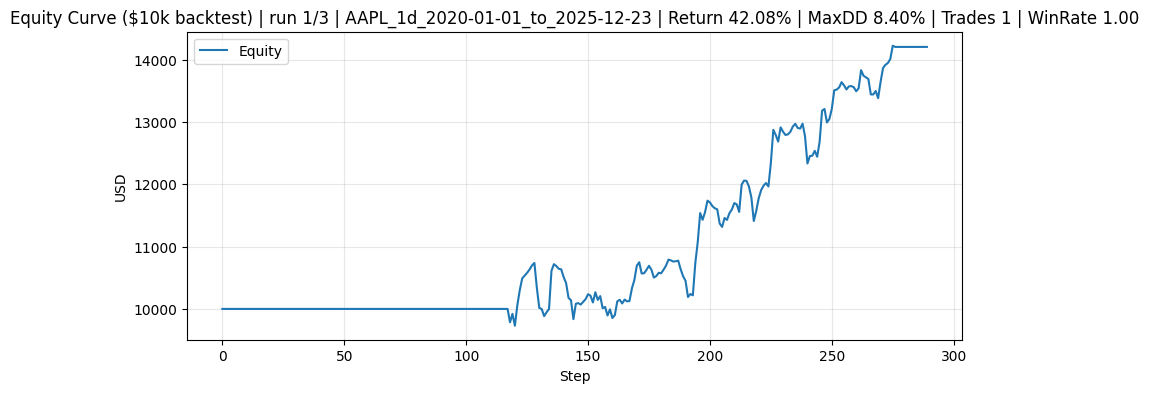


Last 10 trade events:
{'type': 'BUY', 'step': 118, 'price': 198.36000061035156, 'shares': 50.0, 'commission': 9.918000030517579, 'cash_after': 72.08196945190502}
{'type': 'SELL', 'step': 276, 'price': 283.0, 'shares': 50.0, 'commission': 14.15, 'cash_after': 14207.931969451905, 'pnl': 4207.931969451905, 'pnl_pct': 42.38483795398133, 'hold_steps': 158}

Backtest Metrics ($10k, run 2/3):
  instrument: AAPL_1d_2020-01-01_to_2025-12-23
  steps: 290
  initial_cash: 10000.0000
  final_equity: 14207.9320
  total_return_pct: 42.0793
  max_drawdown_pct: 8.4047
  num_round_trips: 1
  win_rate: 1.0000
  avg_hold_steps: 158.0000
  avg_trade_pnl_usd: 4207.9320
  avg_trade_pnl_pct: 42.3848
  action_frac_buy: 0.0242
  action_frac_close: 0.0035
  action_frac_skip: 0.9723
  sizing: all_in
  allow_fractional: False


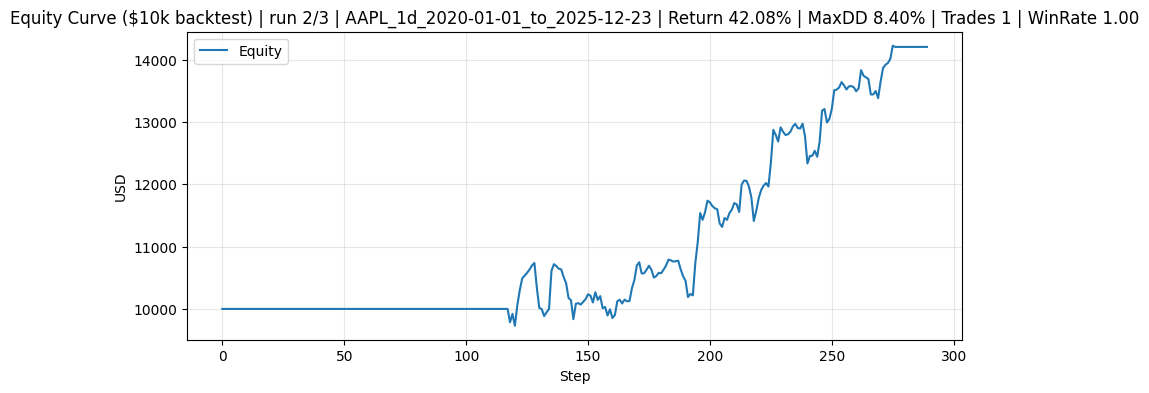


Last 10 trade events:
{'type': 'BUY', 'step': 118, 'price': 198.36000061035156, 'shares': 50.0, 'commission': 9.918000030517579, 'cash_after': 72.08196945190502}
{'type': 'SELL', 'step': 276, 'price': 283.0, 'shares': 50.0, 'commission': 14.15, 'cash_after': 14207.931969451905, 'pnl': 4207.931969451905, 'pnl_pct': 42.38483795398133, 'hold_steps': 158}

Backtest Metrics ($10k, run 3/3):
  instrument: AAPL_1d_2020-01-01_to_2025-12-23
  steps: 184
  initial_cash: 10000.0000
  final_equity: 10792.0817
  total_return_pct: 7.9208
  max_drawdown_pct: 8.4047
  num_round_trips: 0
  win_rate: 0.0000
  avg_hold_steps: 0.0000
  avg_trade_pnl_usd: 0.0000
  avg_trade_pnl_pct: 0.0000
  action_frac_buy: 0.0273
  action_frac_close: 0.0000
  action_frac_skip: 0.9727
  sizing: all_in
  allow_fractional: False


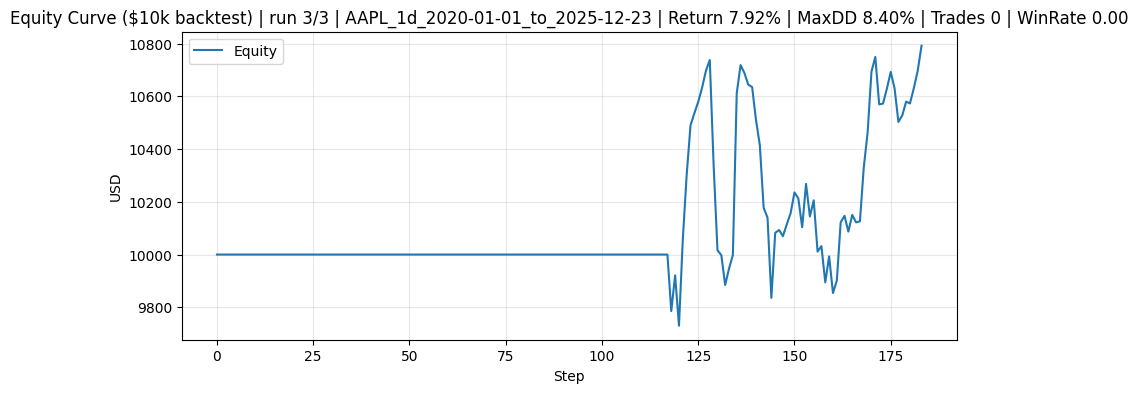


Last 10 trade events:
{'type': 'BUY', 'step': 118, 'price': 198.36000061035156, 'shares': 50.0, 'commission': 9.918000030517579, 'cash_after': 72.08196945190502}


In [11]:
# Cell 10 — $10k backtest + equity curve (POSITION SIZING, executes at OPEN(t+1))
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

# -----------------------------
# Helpers
# -----------------------------
@torch.no_grad()
def act_greedy(model, obs, device):
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    logits, _ = model(obs_t)
    return int(torch.argmax(logits, dim=1).item())

@torch.no_grad()
def act_stochastic(model, obs, device):
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    logits, _ = model(obs_t)
    dist = Categorical(logits=logits)
    return int(dist.sample().item())

def _get_state_and_prices(env):
    base = env.unwrapped if hasattr(env, "unwrapped") else env
    st = base._state
    inst = getattr(base, "_instrument", None)
    opens = st._prices.open
    closes = st._prices.close
    return base, st, opens, closes, inst

def _deterministic_reset(env, instrument: str, start_offset: int):
    """
    Hard reset into a specific instrument + offset (avoids random reset noise).
    Works with your StocksEnv internals: env._prices dict and env._state.reset(prices, offset).
    """
    base = env.unwrapped if hasattr(env, "unwrapped") else env

    # Pick instrument deterministically
    if instrument not in base._prices:
        raise KeyError(f"Instrument {instrument} not found. Available: {list(base._prices.keys())[:5]} ...")

    prices = base._prices[instrument]
    base._instrument = instrument

    st = base._state
    bars = int(st.bars_count)

    # Ensure offset is valid and leaves room for t+1 execution
    ofs = int(max(start_offset, bars))
    ofs = min(ofs, prices.close.shape[0] - 2)  # leave room for open[t+1]
    st.reset(prices, ofs)

    obs = st.encode()
    info = {"instrument": instrument, "offset": ofs, "deterministic": True}
    return obs, info

def backtest_equity_curve_10k(
    env,
    model,
    device,
    initial_cash=10_000.0,
    greedy=True,
    # sizing:
    sizing="all_in",         # "all_in" (default) or "fixed_shares" or "fraction"
    fixed_shares=1,          # used if sizing="fixed_shares"
    fraction=1.0,            # used if sizing="fraction" (e.g., 0.25 = invest 25% of cash)
    allow_fractional=False,  # if True, shares can be fractional
    # determinism:
    instrument=None,         # e.g. "AAPL_1d_2020-01-01_to_2025-12-23"
    start_offset=None,       # e.g. bars_count (start at earliest possible)
    max_steps=None,
    seed=0,
):
    """
    Portfolio backtest (NOT using env reward):
      - Executes at OPEN(t+1)
      - Marks equity at CLOSE(t)
      - Applies commission on entry/exit (same commission_perc as env)
      - Long-only, single position (shares>0 means in position)

    Returns:
      equity_curve, trades, metrics
    """
    model.eval()
    device = torch.device(device) if not isinstance(device, torch.device) else device

    # Reset env (deterministic if instrument provided)
    if instrument is not None and start_offset is not None:
        obs, info = _deterministic_reset(env, instrument=instrument, start_offset=start_offset)
    else:
        obs, info = env.reset(seed=seed)

    base, st, opens, closes, inst = _get_state_and_prices(env)
    if instrument is not None:
        inst = instrument

    fee = float(getattr(st, "commission_perc", 0.0))  # e.g. 0.001

    cash = float(initial_cash)
    shares = 0.0
    entry_price = None
    entry_step = None
    entry_equity = None

    equity_curve = []
    cash_curve = []
    shares_curve = []
    price_curve = []
    actions_curve = []
    trades = []

    terminated = truncated = False
    steps = 0

    while True:
        # Mark-to-market at current CLOSE
        cur_close = float(st._cur_close())
        equity = cash + shares * cur_close

        equity_curve.append(equity)
        cash_curve.append(cash)
        shares_curve.append(shares)
        price_curve.append(cur_close)

        if max_steps is not None and steps >= max_steps:
            break
        if terminated or truncated:
            break

        # Choose action
        action = act_greedy(model, obs, device) if greedy else act_stochastic(model, obs, device)
        actions_curve.append(action)

        # Execution price is next bar OPEN(t+1) (before step)
        next_idx = int(st._offset + 1)
        exec_open = float(opens[next_idx]) if (0 <= next_idx < len(opens)) else None

        # Step env (advances offset internally)
        obs, _r, terminated, truncated, _info = env.step(action)
        steps += 1

        if exec_open is None:
            continue

        # --- Portfolio execution ---
        # Action mapping: 0 Skip, 1 Buy, 2 Close
        if action == Actions.Buy.value:
            if shares <= 0.0:
                # decide shares to buy
                if sizing == "fixed_shares":
                    buy_shares = float(fixed_shares)
                elif sizing == "fraction":
                    spend = max(0.0, min(1.0, float(fraction))) * cash
                    buy_shares = (spend / (exec_open * (1.0 + fee))) if allow_fractional else math.floor(spend / (exec_open * (1.0 + fee)))
                    buy_shares = float(buy_shares)
                else:  # "all_in"
                    buy_shares = (cash / (exec_open * (1.0 + fee))) if allow_fractional else math.floor(cash / (exec_open * (1.0 + fee)))
                    buy_shares = float(buy_shares)

                if buy_shares > 0:
                    cost = buy_shares * exec_open
                    commission = cost * fee
                    total_cost = cost + commission

                    if cash >= total_cost - 1e-9:
                        cash -= total_cost
                        shares = buy_shares
                        entry_price = exec_open
                        entry_step = steps
                        entry_equity = equity  # equity just before entry (close-based)

                        trades.append({
                            "type": "BUY",
                            "step": steps,
                            "price": exec_open,
                            "shares": shares,
                            "commission": commission,
                            "cash_after": cash,
                        })

        elif action == Actions.Close.value:
            if shares > 0.0:
                proceeds = shares * exec_open
                commission = proceeds * fee
                net_proceeds = proceeds - commission
                cash += net_proceeds

                # Trade PnL (portfolio-level) using entry/exit prices and commissions
                # Net cost at entry: shares*entry_price + entry_commission
                # Net proceeds at exit: shares*exit_price - exit_commission
                entry_cost = shares * float(entry_price)
                entry_comm = entry_cost * fee
                exit_proceeds = shares * exec_open
                exit_comm = exit_proceeds * fee
                pnl = (exit_proceeds - exit_comm) - (entry_cost + entry_comm)

                # Percent vs invested capital (entry_cost + entry_comm)
                denom = (entry_cost + entry_comm) if (entry_cost + entry_comm) > 1e-9 else 1.0
                pnl_pct = 100.0 * (pnl / denom)

                trades.append({
                    "type": "SELL",
                    "step": steps,
                    "price": exec_open,
                    "shares": shares,
                    "commission": commission,
                    "cash_after": cash,
                    "pnl": pnl,
                    "pnl_pct": pnl_pct,
                    "hold_steps": (steps - entry_step) if entry_step is not None else None,
                })

                shares = 0.0
                entry_price = None
                entry_step = None
                entry_equity = None

    # Final MTM equity
    cur_close = float(st._cur_close())
    final_equity = cash + shares * cur_close

    equity_curve = np.asarray(equity_curve, dtype=np.float64)
    price_curve = np.asarray(price_curve, dtype=np.float64)
    actions_curve = np.asarray(actions_curve, dtype=np.int64) if len(actions_curve) else np.zeros(0, dtype=np.int64)

    # Metrics
    total_return = (final_equity / float(initial_cash)) - 1.0

    # Max drawdown on equity curve
    peak = equity_curve[0] if len(equity_curve) else float(initial_cash)
    max_dd = 0.0
    for x in equity_curve:
        peak = max(peak, x)
        dd = (peak - x) / max(peak, 1e-12)
        max_dd = max(max_dd, dd)

    sells = [t for t in trades if t["type"] == "SELL"]
    n_trades = len(sells)
    wins = sum(1 for t in sells if float(t.get("pnl", 0.0)) > 0.0)
    win_rate = (wins / n_trades) if n_trades > 0 else 0.0

    avg_hold = float(np.mean([t["hold_steps"] for t in sells if t.get("hold_steps") is not None])) if n_trades > 0 else 0.0
    avg_trade_pnl_pct = float(np.mean([t["pnl_pct"] for t in sells])) if n_trades > 0 else 0.0
    avg_trade_pnl_usd = float(np.mean([t["pnl"] for t in sells])) if n_trades > 0 else 0.0

    # Action fractions (sanity)
    af_buy = float(np.mean(actions_curve == Actions.Buy.value)) if len(actions_curve) else 0.0
    af_close = float(np.mean(actions_curve == Actions.Close.value)) if len(actions_curve) else 0.0
    af_skip = float(np.mean(actions_curve == Actions.Skip.value)) if len(actions_curve) else 0.0

    metrics = {
        "instrument": inst,
        "steps": int(len(equity_curve)),
        "initial_cash": float(initial_cash),
        "final_equity": float(final_equity),
        "total_return_pct": float(total_return * 100.0),
        "max_drawdown_pct": float(max_dd * 100.0),
        "num_round_trips": int(n_trades),
        "win_rate": float(win_rate),
        "avg_hold_steps": float(avg_hold),
        "avg_trade_pnl_usd": float(avg_trade_pnl_usd),
        "avg_trade_pnl_pct": float(avg_trade_pnl_pct),
        "action_frac_buy": af_buy,
        "action_frac_close": af_close,
        "action_frac_skip": af_skip,
        "sizing": sizing,
        "allow_fractional": bool(allow_fractional),
    }

    return {
        "equity_curve": equity_curve,
        "cash_curve": np.asarray(cash_curve, dtype=np.float64),
        "shares_curve": np.asarray(shares_curve, dtype=np.float64),
        "price_curve": price_curve,
        "actions_curve": actions_curve,
        "trades": trades,
        "metrics": metrics,
    }

def plot_equity(result, title="Equity Curve ($10k backtest)"):
    eq = result["equity_curve"]
    m = result["metrics"]

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(eq, label="Equity")
    ax.set_title(
        f"{title} | {m.get('instrument')} | "
        f"Return {m['total_return_pct']:.2f}% | MaxDD {m['max_drawdown_pct']:.2f}% | "
        f"Trades {m['num_round_trips']} | WinRate {m['win_rate']:.2f}"
    )
    ax.set_xlabel("Step")
    ax.set_ylabel("USD")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()

# -----------------------------
# Load best model & run backtest
# -----------------------------
best_path = os.path.join("saves", f"ppo_{config['run_name']}_best.pt")
if not os.path.exists(best_path):
    print(f"Best model checkpoint not found: {best_path}")
else:
    state = torch.load(best_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    print(f"Loaded best model from: {best_path}")

    # ---- Deterministic backtest (recommended for 3 repeats) ----
    # Use the same instrument + same starting offset each time so runs are comparable.
    # If you want the FULL history from earliest possible, start_offset = bars_count.
    instrument_name = "AAPL_1d_2020-01-01_to_2025-12-23"
    start_offset = int(config["bars"])  # earliest valid

    for run_i in range(1, 4):
        bt = backtest_equity_curve_10k(
            env=env_val,
            model=model,
            device=device,
            initial_cash=10_000.0,
            greedy=True,
            sizing="all_in",          # <<< FIX: all-in position sizing
            allow_fractional=False,   # integer shares by default
            instrument=instrument_name,
            start_offset=start_offset,
            max_steps=None,
            seed=run_i,               # only used if you remove deterministic instrument/offset
        )

        print("\n" + "=" * 60)
        print(f"Backtest Metrics ($10k, run {run_i}/3):")
        print("=" * 60)
        for k, v in bt["metrics"].items():
            if isinstance(v, float):
                print(f"  {k}: {v:.4f}")
            else:
                print(f"  {k}: {v}")
        print("=" * 60)

        plot_equity(bt, title=f"Equity Curve ($10k backtest) | run {run_i}/3")

        print("\nLast 10 trade events:")
        for t in bt["trades"][-10:]:
            print(t)

In [19]:
# Cell 10 — Build a deterministic backtest environment (NO random offset)
import gymnasium as gym

# pick the instrument you want to backtest
BACKTEST_INSTRUMENT = "AAPL_1d_2020-01-01_to_2025-12-23"
if BACKTEST_INSTRUMENT not in prices_val:
    # fallback: pick first available
    BACKTEST_INSTRUMENT = list(prices_val.keys())[0]
print("Backtest instrument:", BACKTEST_INSTRUMENT)

# Make a single-instrument dict (no random instrument selection)
prices_bt = {BACKTEST_INSTRUMENT: prices_val[BACKTEST_INSTRUMENT]}

# IMPORTANT: random_ofs_on_reset=False makes start deterministic (offset = bars_count)
env_bt_base = StocksEnv(
    prices_bt,
    bars_count=config["bars"],
    volumes=config["volumes"],
    extra_features=config["extra_features"],
    reward_mode=config["reward_mode"],
    state_1d=config["state_1d"],
    hold_penalty_per_step=float(config["hold_penalty_per_step"]),
    max_hold_steps=config.get("max_hold_steps", None),

    # KEY FIX:
    random_ofs_on_reset=False,
)
env_bt = gym.wrappers.TimeLimit(env_bt_base, max_episode_steps=config["time_limit"])

print("✓ Backtest env created (deterministic reset)")


Backtest instrument: AAPL_1d_2020-01-01_to_2025-12-23
✓ Backtest env created (deterministic reset)


Loaded best model from: saves\ppo_ppo_aapl_final_holdpen_2e-4_closebonus_0p15_uloss_0p10_uvol_0p00_best.pt

Backtest Metrics ($10k, run 1/3):
  instrument: AAPL_1d_2020-01-01_to_2025-12-23
  steps: 290
  initial_cash: 10000.0000
  final_equity: 14207.9320
  total_return_pct: 42.0793
  max_drawdown_pct: 8.4047
  num_round_trips: 1
  win_rate: 1.0000
  avg_hold_steps: 158.0000
  avg_trade_pnl_usd: 4232.0000
  avg_trade_pnl_pct: 42.6699
  action_frac_buy: 0.0242
  action_frac_close: 0.0035
  action_frac_skip: 0.9723
  sizing: all_in
  allow_fractional: False


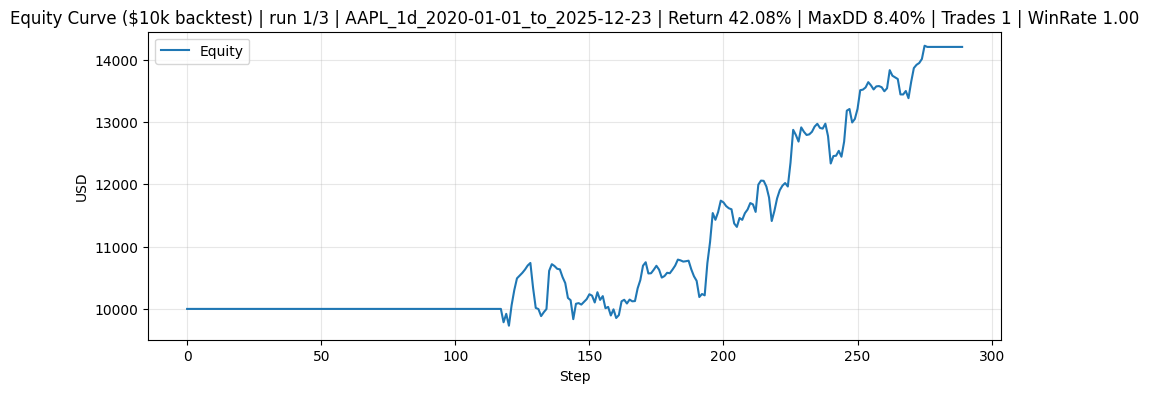


Last 10 trade events:
{'type': 'BUY', 'step': 118, 'price': 198.36000061035156, 'shares': 50.0, 'commission': 9.918000030517579, 'cash_after': 72.08196945190502}
{'type': 'SELL', 'step': 276, 'price': 283.0, 'shares': 50.0, 'commission': 14.15, 'cash_after': 14207.931969451905, 'pnl': 4231.999969482422, 'pnl_pct': 42.669892684619924, 'hold_steps': 158}

Backtest Metrics ($10k, run 2/3):
  instrument: AAPL_1d_2020-01-01_to_2025-12-23
  steps: 290
  initial_cash: 10000.0000
  final_equity: 14207.9320
  total_return_pct: 42.0793
  max_drawdown_pct: 8.4047
  num_round_trips: 1
  win_rate: 1.0000
  avg_hold_steps: 158.0000
  avg_trade_pnl_usd: 4232.0000
  avg_trade_pnl_pct: 42.6699
  action_frac_buy: 0.0242
  action_frac_close: 0.0035
  action_frac_skip: 0.9723
  sizing: all_in
  allow_fractional: False


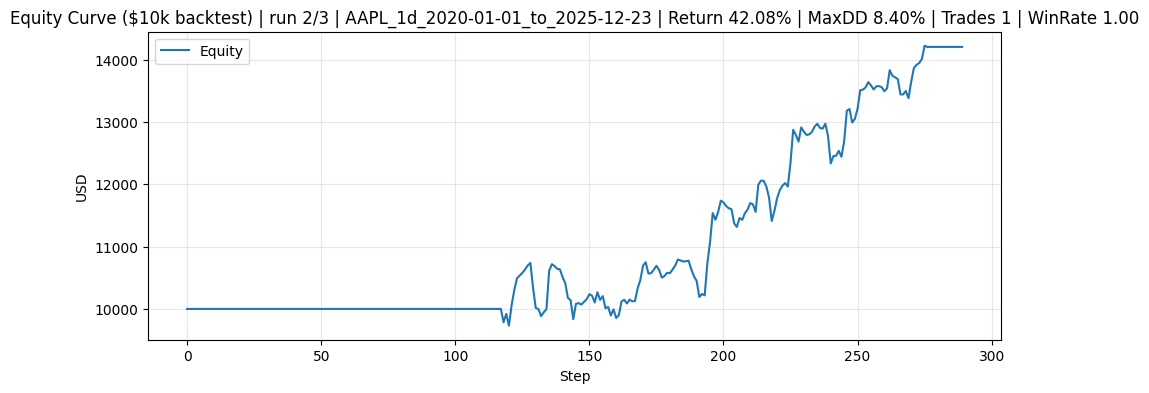


Last 10 trade events:
{'type': 'BUY', 'step': 118, 'price': 198.36000061035156, 'shares': 50.0, 'commission': 9.918000030517579, 'cash_after': 72.08196945190502}
{'type': 'SELL', 'step': 276, 'price': 283.0, 'shares': 50.0, 'commission': 14.15, 'cash_after': 14207.931969451905, 'pnl': 4231.999969482422, 'pnl_pct': 42.669892684619924, 'hold_steps': 158}

Backtest Metrics ($10k, run 3/3):
  instrument: AAPL_1d_2020-01-01_to_2025-12-23
  steps: 290
  initial_cash: 10000.0000
  final_equity: 14207.9320
  total_return_pct: 42.0793
  max_drawdown_pct: 8.4047
  num_round_trips: 1
  win_rate: 1.0000
  avg_hold_steps: 158.0000
  avg_trade_pnl_usd: 4232.0000
  avg_trade_pnl_pct: 42.6699
  action_frac_buy: 0.0242
  action_frac_close: 0.0035
  action_frac_skip: 0.9723
  sizing: all_in
  allow_fractional: False


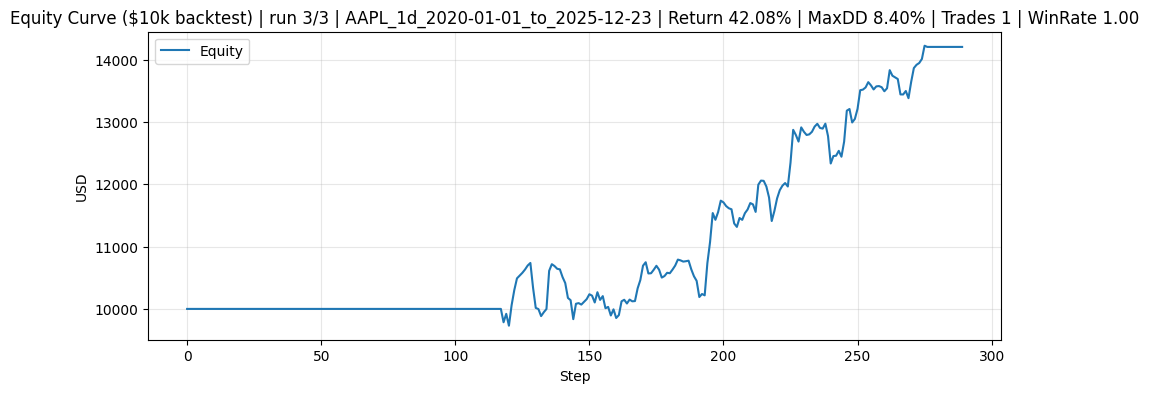


Last 10 trade events:
{'type': 'BUY', 'step': 118, 'price': 198.36000061035156, 'shares': 50.0, 'commission': 9.918000030517579, 'cash_after': 72.08196945190502}
{'type': 'SELL', 'step': 276, 'price': 283.0, 'shares': 50.0, 'commission': 14.15, 'cash_after': 14207.931969451905, 'pnl': 4231.999969482422, 'pnl_pct': 42.669892684619924, 'hold_steps': 158}


In [20]:
# Cell 11 — $10k backtest + equity curve (deterministic)
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

@torch.no_grad()
def act_greedy(model, obs, device):
    obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
    logits, _ = model(obs_t)
    return int(torch.argmax(logits, dim=1).item())

def _get_price_series(base_env):
    st = base_env._state
    inst = getattr(base_env, "_instrument", None)
    opens = st._prices.open
    closes = st._prices.close
    return opens, closes, inst

def backtest_all_in(
    env,
    model,
    device,
    initial_cash=10_000.0,
    greedy=True,
    allow_fractional=False,
    seed=0,
):
    """
    Deterministic backtest on env.
    - Trades 'all-in' on BUY (max shares possible)
    - Flat on CLOSE
    - Commission charged on entry and exit (same as env)
    - Equity marked on CLOSE each step
    """
    model.eval()
    base_env = env.unwrapped if hasattr(env, "unwrapped") else env

    obs, info = env.reset(seed=seed)
    opens, closes, inst = _get_price_series(base_env)
    st = base_env._state
    fee = float(getattr(st, "commission_perc", 0.0))

    cash = float(initial_cash)
    shares = 0.0
    entry_price = None
    entry_step = None

    equity_curve, price_curve = [], []
    trades = []

    act_counts = {0: 0, 1: 0, 2: 0}

    terminated = truncated = False
    steps = 0

    while True:
        cur_close = float(st._cur_close())
        equity = cash + shares * cur_close
        equity_curve.append(equity)
        price_curve.append(cur_close)

        if terminated or truncated:
            break

        # action
        if greedy:
            action = act_greedy(model, obs, device)
        else:
            obs_t = torch.as_tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            logits, _ = model(obs_t)
            dist = Categorical(logits=logits)
            action = int(dist.sample().item())

        act_counts[action] += 1

        # execution open = OPEN(t+1) (must compute BEFORE env.step)
        next_idx = int(st._offset + 1)
        exec_open = float(opens[next_idx]) if (0 <= next_idx < len(opens)) else None

        obs, reward, terminated, truncated, info = env.step(action)
        steps += 1

        if exec_open is None:
            continue

        # portfolio mechanics
        if action == Actions.Buy.value:
            if shares == 0.0:
                # all-in sizing
                max_affordable = cash / (exec_open * (1.0 + fee))
                if not allow_fractional:
                    max_affordable = float(int(max_affordable))
                if max_affordable > 0:
                    commission = exec_open * max_affordable * fee
                    cash -= exec_open * max_affordable + commission
                    shares = max_affordable
                    entry_price = exec_open
                    entry_step = steps
                    trades.append({
                        "type": "BUY",
                        "step": steps,
                        "price": exec_open,
                        "shares": shares,
                        "commission": commission,
                        "cash_after": cash,
                    })

        elif action == Actions.Close.value:
            if shares > 0.0:
                commission = exec_open * shares * fee
                cash += exec_open * shares - commission

                pnl = (exec_open - float(entry_price)) * shares if entry_price is not None else 0.0
                pnl_pct = ((exec_open - float(entry_price)) / float(entry_price) * 100.0) if entry_price else 0.0

                trades.append({
                    "type": "SELL",
                    "step": steps,
                    "price": exec_open,
                    "shares": shares,
                    "commission": commission,
                    "cash_after": cash,
                    "pnl": pnl,
                    "pnl_pct": pnl_pct,
                    "hold_steps": (steps - entry_step) if entry_step is not None else None,
                })

                shares = 0.0
                entry_price = None
                entry_step = None

    equity_curve = np.asarray(equity_curve, dtype=np.float64)

    # metrics
    final_equity = float(equity_curve[-1])
    total_return = (final_equity / initial_cash) - 1.0

    peak = equity_curve[0]
    max_dd = 0.0
    for x in equity_curve:
        peak = max(peak, x)
        max_dd = max(max_dd, (peak - x) / max(peak, 1e-9))

    sells = [t for t in trades if t["type"] == "SELL"]
    n = len(sells)
    win_rate = (sum(1 for t in sells if t.get("pnl", 0.0) > 0.0) / n) if n else 0.0
    avg_hold = float(np.mean([t["hold_steps"] for t in sells])) if n else 0.0
    avg_pnl_usd = float(np.mean([t["pnl"] for t in sells])) if n else 0.0
    avg_pnl_pct = float(np.mean([t["pnl_pct"] for t in sells])) if n else 0.0

    total_actions = max(1, sum(act_counts.values()))
    metrics = {
        "instrument": inst,
        "steps": len(equity_curve),
        "initial_cash": float(initial_cash),
        "final_equity": final_equity,
        "total_return_pct": float(total_return * 100.0),
        "max_drawdown_pct": float(max_dd * 100.0),
        "num_round_trips": int(n),
        "win_rate": float(win_rate),
        "avg_hold_steps": float(avg_hold),
        "avg_trade_pnl_usd": float(avg_pnl_usd),
        "avg_trade_pnl_pct": float(avg_pnl_pct),
        "action_frac_buy": act_counts[1] / total_actions,
        "action_frac_close": act_counts[2] / total_actions,
        "action_frac_skip": act_counts[0] / total_actions,
        "sizing": "all_in",
        "allow_fractional": bool(allow_fractional),
    }

    return {"equity_curve": equity_curve, "trades": trades, "metrics": metrics}

def plot_equity(eq, title):
    plt.figure(figsize=(11,4))
    plt.plot(eq, label="Equity")
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel("USD")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# -----------------------------
# Load best model
# -----------------------------
best_path = os.path.join("saves", f"ppo_{config['run_name']}_best.pt")
if not os.path.exists(best_path):
    raise FileNotFoundError(f"Best model checkpoint not found: {best_path}")

state = torch.load(best_path, map_location=device)
model.load_state_dict(state)
model.to(device)
print(f"Loaded best model from: {best_path}")

# -----------------------------
# Run 3 deterministic backtests
# -----------------------------
for i in range(3):
    bt = backtest_all_in(
        env=env_bt,
        model=model,
        device=device,
        initial_cash=10_000.0,
        greedy=True,
        allow_fractional=False,
        seed=0,   # keep fixed for deterministic reset
    )

    m = bt["metrics"]
    print("\n" + "="*60)
    print(f"Backtest Metrics ($10k, run {i+1}/3):")
    print("="*60)
    for k, v in m.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
    print("="*60)

    plot_equity(
        bt["equity_curve"],
        title=(
            f"Equity Curve ($10k backtest) | run {i+1}/3 | {m['instrument']} | "
            f"Return {m['total_return_pct']:.2f}% | MaxDD {m['max_drawdown_pct']:.2f}% | "
            f"Trades {m['num_round_trips']} | WinRate {m['win_rate']:.2f}"
        ),
    )

    print("\nLast 10 trade events:")
    for t in bt["trades"][-10:]:
        print(t)
